##Module 6.2: Naive Online Q-Learning

We implement a basic online DQN based reinforcement learning system to control the cart-pole environment from AI Gym.

In this module we will pay attention to:
- The RL environment
- The DQN
- SARS learning
- Epsilon learning

And we will probably see instability!

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

We import required libraries.

In [0]:
from gym.wrappers import TimeLimit
from gym.envs.classic_control import CartPoleEnv

import numpy as np
import random
import time

from keras.optimizers import Adam
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


We start by setting up the Cart-Pole environment from AI gym. 

In this 2d environment, you control a cart that can move left or right on a rail, and seeks to keep a rigid pole with 15 degrees of vertical. The episode ends if the pole falls outside this range, or if the cart moves more than 2.4 units from center. There is a reward of 1 each turn.

We will render a video of the system in the next module, but you can also watch one at: https://youtu.be/Qk61tqRrj0E

We will impose a time-limit of 250 steps on our environment.


In [0]:
env = TimeLimit(CartPoleEnv(),max_episode_steps=251)

Now we make a function that will control and train a deep learning RL system using online SARS, epsilon-Q learning.

In [0]:
def naive_deep_q_learning_episode_control (
    env,
    qNet,
    epsilon,
    epsilon_min,
    epsilon_decay,
    gamma
    ):
  # Setup reward count
  total_reward=0

  # Start new episode
  env.reset()

  # Initial random move to get pole and cart moving
  state, reward, done, _ = env.step(env.action_space.sample())
  state = np.reshape(state, [1, 4])
  
  # We create a control loop that will continue until the
  # episode is finished.
  done = False
  while not done:
    # Determine action
    if np.random.rand() <= epsilon:
      # Make a random action
      action = env.action_space.sample()
    else:
      # Otherwise get action from Q-estimates
      Qs = qNet.predict(state)
      action = np.argmax(Qs)            
    
    # Take action, get new state and reward
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, 4])
    
    # Train network from latest SARS datum
    # 1. Estimate Q-values for all actions in current state
    q_values = qNet.predict(state)
    # 2. Get current estimate of action's q-value
    if done:
      # If episode is finished, this is current reward
      q_values[0,action] = reward
    else:
      # Otherwise it is current reward plus discounted Q-value
      # of expected best action from next_state
      q_values[0,action] = reward + gamma * np.amax(qNet.predict(next_state)[0])
    # 3. Train network on single batch of single SARS datum
    qNet.fit(state,q_values,batch_size=1,epochs=1,verbose=0)

    # Adjust epsilon
    if epsilon>epsilon_min:
      epsilon*=epsilon_decay

    # Update local variables
    state=next_state
    total_reward += reward

  # the episode has ended, so return updated network,
  # epsilon value and total rewards
  return qNet,epsilon,total_reward


We create a wrapper function that will make a suitable DQN for this environment.

In [0]:
def make_DQN(state_size=4, action_size=2, hidden_size=256):
  inputs = Input(shape=(state_size, ), name='state')
  h1 = Dense(hidden_size, activation='relu')(inputs)
  h2 = Dense(hidden_size, activation='relu')(h1)
  h3 = Dense(hidden_size, activation='relu')(h2)
  outputs = Dense(action_size, activation='linear', name='action')(h3)
  model = Model(inputs, outputs)
  model.summary()
  optimizer = Adam()
  model.compile(loss='mse', optimizer=optimizer)
  return model

And another wrapper function that will create the DQN and train it over a number of episodes.

In [0]:
def run_naive_rl(env):
  # Create our DQN
  qNet=make_DQN()

  # Specify required RL parameters
  epsilon=.9
  epsilon_decay=.99995
  epsilon_min=.1
  gamma=.9

  # Specify number of episodes and reporting parameters.
  episodes=3000
  report_every=100
  final_rewards=np.zeros(episodes)
  time_start=time.clock()
  
  # Loop through desired number of episodes
  for ep in range(episodes):
    # Here we call our control function
    qNet,epsilon,total_reward=naive_deep_q_learning_episode_control (
      env,
      qNet,
      epsilon,
      epsilon_min,
      epsilon_decay,
      gamma)
    # Now we record results and report on them periodically
    final_rewards[ep]=total_reward
    if ep!=0 and ep % report_every == 0:
      time_end=time.clock()
      mean_reward=np.sum(final_rewards[ep-report_every:ep+1])/report_every
      print('Episode: {}'.format(ep),
        'Recent Average Rewards: {}'.format(mean_reward),
        'Epsilon: {:.4f}'.format(epsilon),
        'Time: {:.2f}'.format(time_end-time_start))
      time_start=time_end
      # We arbitrarily decide that a mean reward > 195 over the reporting
      # period (remember the time limit was only 250) means we've solved
      # the problem to our satisfaction. 
      # Actually, we haven't really - the control will not have learnt to
      # keep the cart in the middle of the rail.
      if mean_reward>195:
        print("Problem is considered solved!!!")
        return final_rewards
        
  print("Problem was not solved.") 
  return qNet,epsilon,final_rewards

Let's run our training function and see how we go...

In [0]:
qNet,final_epsilon,results=run_naive_rl(env)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1280      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
action (Dense)               (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
Episode: 100 Recent Average Rewards: 23.69 Epsilon: 0.7995 Time: 12.56
Episode: 200 Recent Average Rewards: 31.37 Epsil

Let's have a look at the training history. We'll average over results inside the reporting sets intervals to match the numbers above.

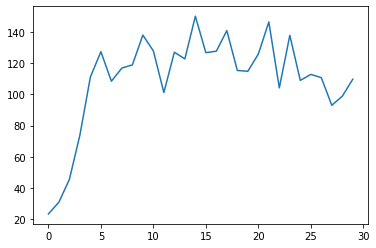

In [0]:
import matplotlib.pyplot as plt
smooth_over=100
R_=[np.mean(results[smooth_over*i:smooth_over*(i+1)]) for i in range(int(results.shape[0]/smooth_over))]
plt.plot(R_)
plt.show()